# コサイン類似度によるムービーレコメンデーション学習用

レコメンデーションシステムは、ユーザーに「関連性のある」提案を提供する機械学習アルゴリズムの重要なクラスです。Youtube、Amazon、Netflix などは、すべてレコメンデーションシステムで機能しており、システムがあなたの過去の活動に基づいて（コンテンツベースのフィルタリング）、またはあなたと似たような他のユーザーの活動や好みに基づいて、次のビデオや商品を推薦してくれます（コラボレーションフィルタリング）。同様に、 Facebook もレコメンデーションシステムを利用して、オフラインで知り合いの Facebook ユーザーを推薦しています。

レコメンデーションシステムは、コンテンツまたはコンテンツにアクセスしたユーザー間の類似性に基づいて機能します。
2つのアイテム間の類似性を測定する方法はいくつかあります。レコメンデーションシステムは、この類似度マトリックスを使用して、次に最も類似した商品をユーザーに推薦します。
このノートブックでは、ユーザーが好きな映画に基づいて映画を推薦する機械学習アルゴリズムを構築します。この機械学習モデルはコサイン類似度に基づいています。

## より高度で大規模なレコメンデーションシステムの構築は以下を参照してください

- [Light FM 近似最近傍探索](02_ANN_annoy_nsmlib_example.ipynb)
- [Light FM Hybrid matrix factorisation model](https://github.com/microsoft/recommenders/blob/master/examples/02_model_hybrid/lightfm_deep_dive.ipynb)

## 参考
https://github.com/codeheroku/Introduction-to-Machine-Learning/tree/master/Building%20a%20Movie%20Recommendation%20Engine

## Setup

映画レコメンドシステムを構築するための最初のステップは、適切なデータを得ることです。映画のデータセットはウェブからダウンロードするか、以下のリンクから "movie_dataset.csv "というタイトルの 22MB の CSV ファイルをダウンロードすることができます。

インデックス、予算、ジャンル、ホームページ、ID、キーワード、オリジナル言語、オリジナルタイトル、概要、人気、制作会社、制作国、公開日、収益、ランタイム、音声言語、ステータス、キャッチフレーズ、タイトル、投票平均値、投票数、キャスト、スタッフ、監督の 24 カラムの合計 4803 本の映画が CSV ファイルに含まれています。

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from matplotlib import pyplot as plt
%matplotlib inline

df = pd.read_csv(r"movie_dataset.csv")

df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


## 特徴量リスト

使用する特徴量のリストを作成します。前述したように、我々の問題を考慮して、最も関連性の高い特徴量のみを使用します。したがって、私たちが選んだ特徴量は、キーワード、キャスト、ジャンル、監督になります。

ホラー映画が好きなユーザーは、ほとんどの場合、別のホラー映画を好きになるでしょう。あるユーザーは、自分の好きな俳優が出演している映画を見るのが好きなのかもしれません。また、特定の人物が監督した映画が好きな人もいるでしょう。これらすべての要素を組み合わせることで、私たちの推薦アルゴリズムを訓練するのに十分な 4 つの特徴が得られます。


さらに、少しだけデータの前処理を行い、NaN 値を持つ行をスペース/空の文字列に置き換えることで、コードを実行している間にエラーが発生しないようにします。この前処理は for ループで行っています。

In [2]:
features = ['keywords', 'cast', 'genres', 'director']
for feature in features:
    df[feature] = df[feature].fillna('')
    
df[feature]

0           James Cameron
1          Gore Verbinski
2              Sam Mendes
3       Christopher Nolan
4          Andrew Stanton
              ...        
4798     Robert Rodriguez
4799         Edward Burns
4800          Scott Smith
4801          Daniel Hsia
4802     Brian Herzlinger
Name: director, Length: 4803, dtype: object

## 関連する特徴量を1つの特徴量にまとめる

次に、 combined_features という関数を定義します。この関数は、便利な機能（キーワード、キャスト、ジャンル、監督）をそれぞれの行から結合し、結合された特徴量を1つの文字列にまとめた行を返します。

既存のデータフレーム(df)に新しい列、combined_features を追加し、各行(axis = 1)に上記の関数を適用します。これで、データフレームの最後に新たな列が追加され、結合された特徴の行で構成されるようになります。

In [3]:
def combined_features(row):
    return row['keywords']+" "+row['cast']+" "+row['genres']+" "+row['director']

df["combined_features"] = df.apply(combined_features, axis =1)

df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director,combined_features
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron,culture clash future space war space colony so...
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski,ocean drug abuse exotic island east india trad...
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes,spy based on novel secret agent sequel mi6 Dan...
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan,dc comics crime fighter terrorist secret ident...
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton,based on novel mars medallion space travel pri...


## 特徴量の抽出

[sklearn.feature_extraction](https://scikit-learn.org/stable/modules/feature_extraction.html) モジュールは、テキストや画像などの形式からなるデータセットから、機械学習アルゴリズムでサポートされている形式の特徴量を抽出するために利用できます。今回は CountVectorizer の fit および tranform を使ってテキストの数をカウントし、変換した[スパース行列](https://ja.wikipedia.org/wiki/%E7%96%8E%E8%A1%8C%E5%88%97) count_matrix を配列に出力して理解を深めていきます。

ここで、ベクトル化は、テキストドキュメントのコレクションを数値の特徴ベクトルに変換する一般的なプロセスです。この特定の戦略（トークン化、カウント、および正規化）は、Bag of Words または「Bag of n-grams」表現と呼ばれます。ドキュメントは、ドキュメント内の単語の相対的な位置情報を完全に無視して、単語の出現回数によって記述されます。

ここでは、*combined_features* 列から取り出された単語一つ一つに対して、特定の映画の特徴量(キーワード、キャスト、ジャンル、監督)の出現回数を数えます。

In [198]:
# CoutVectorizer　語彙辞書を作成する
vectorizer = CountVectorizer()
vectorizer.fit(df["combined_features"])

# 語彙辞書のサイズ
print('Vocabulary size: {}'.format(len(vectorizer.vocabulary_)))

# 語彙辞書の中身を見る
#print('Vocabulary content: {}'.format(vectorizer.vocabulary_))

# ベクトル化処理
count_matrix = vectorizer.transform(df["combined_features"])

count_matrix

Vocabulary size: 14845


<4803x14845 sparse matrix of type '<class 'numpy.int64'>'
	with 97547 stored elements in Compressed Sparse Row format>

CountVectorizer の `fit` を用いて 14845 列の語彙辞書を作成しました。`transform` はこの辞書を参照し、*combined_features* 列をベクトル化すると、4803行、14845 列の特徴量を持ったスパース行列に変換されます。`fit_transform` を用いて一度にこれらの処理を行うこともできます。

count_matrix は *scipy.sparse.csr.csr_matrix* 形式で作成されます。この形式は、成分のほとんどが 0 であるスパース行列を圧縮しているため、メモリ使用量が少なく処理速度も高速になるというメリットがあります。このオブジェクトが持つプロパティを以下に列挙します。

In [161]:
print(type(count_matrix))

# 特定の行についてのプロパティ
print(count_matrix[199].__dict__)

<class 'scipy.sparse.csr.csr_matrix'>
{'_shape': (1, 14845), 'maxprint': 50, 'indices': array([   86,   144,  1451,  1508,  2792,  3284,  3461,  3974,  4337,
        4435,  5077,  5247,  5288,  6318,  6450,  6492,  6744,  7048,
        7247,  8371,  9791, 10590, 11394, 13329, 14017]), 'indptr': array([ 0, 25]), 'data': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1], dtype=int64)}


全映画のリストの特徴量（スパース行列）を可視化するには、`plt.spy` を使用します。

Text(0, 0.5, 'movie index')

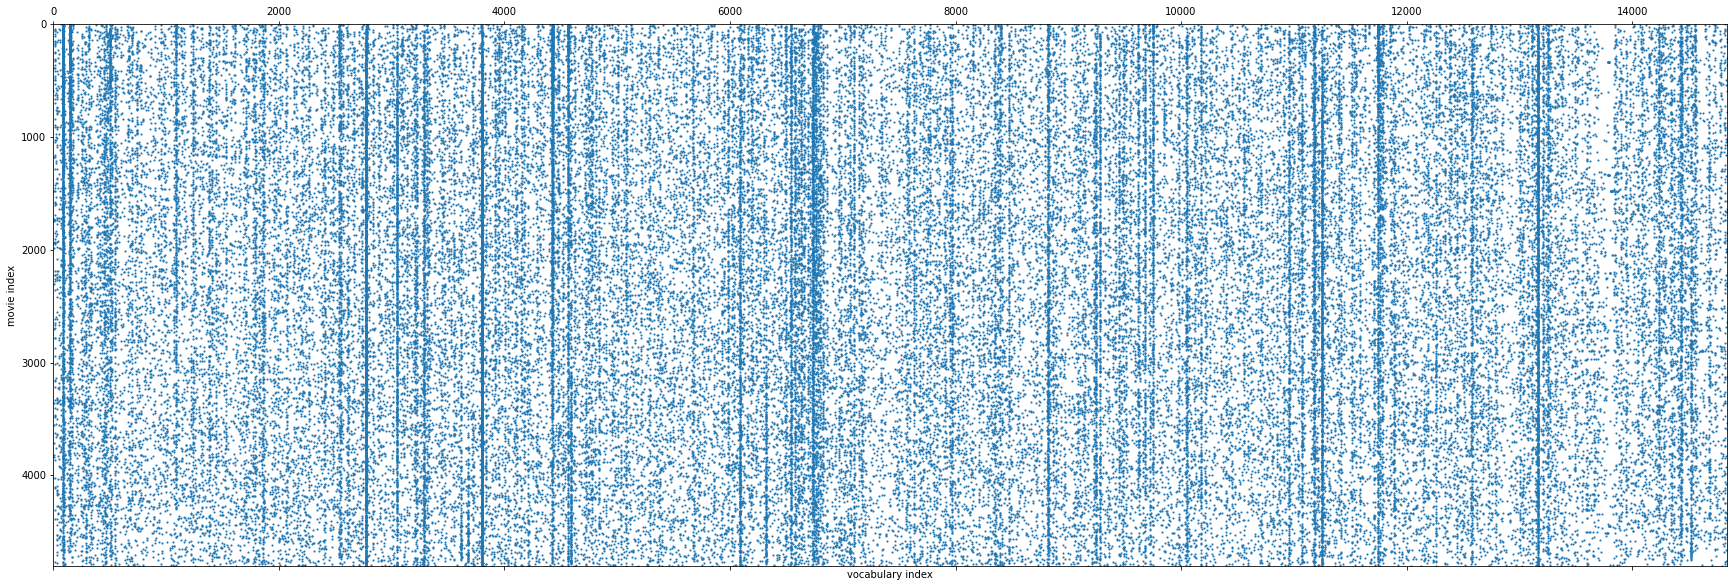

In [185]:
plt.figure(figsize=(30, 30))
plt.spy(count_matrix, markersize=1)
plt.xlabel('vocabulary index')
plt.ylabel('movie index')

この図はスパース行列全体を俯瞰的に見るのに適しています。

ここでは、*action* や *fantasy* のような多くの映画に共通に見られる単語の部分が色が濃くなっています。

## 類似性の探索

ある映画に対して、類似の特徴量を見つけるにはどのようにすればよいでしょうか。

ひとまず、以下の映画のスパース行列を並べてみましょう。

- 199: Pirates of the Caribbean: The Curse of the Black Pearl
- 1: Pirates of the Caribbean: At World's End
- 12: Pirates of the Caribbean: Dead Man's Chest
- 343: Toy Story 2

Text(0.5, 0, 'vocabulary index')

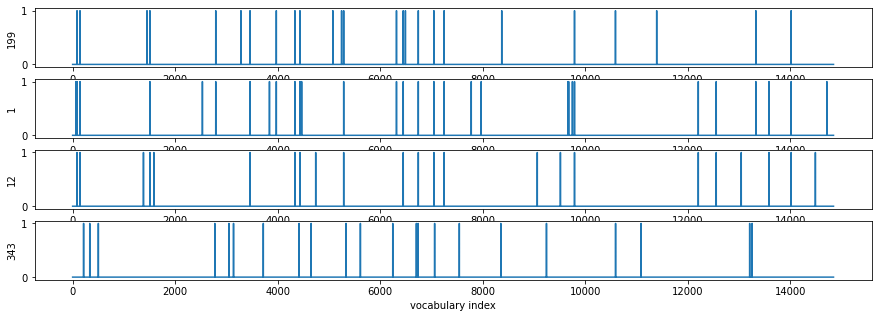

In [204]:
fig, ax = plt.subplots(figsize=(15,5))
plt.subplot(4,1,1)  # 1段目の図
plt.plot(count_matrix[199].toarray()[0])
plt.ylabel('199')

plt.subplot(4,1,2)  # 2段目の図
plt.plot(count_matrix[1].toarray()[0])
plt.ylabel('1')

plt.subplot(4,1,3)  # 3段目の図
plt.plot(count_matrix[12].toarray()[0])
plt.ylabel('12')

plt.subplot(4,1,4)  # 4段目の図
plt.plot(count_matrix[343].toarray()[0])
plt.ylabel('343')
plt.xlabel('vocabulary index')

同じ単語が含まれる場合は、同じ vocabulary index の位置にカウントされます。

それぞれの映画ごとにグラフの形に注目してください。

1～3番目の映画までは形がよく似ていると思いますが、4 番目の映画は全く違うことが見て取れます。

では、映画ごとの特徴量（語彙）の列を出力してみましょう。
count_matrix から語彙辞書へマッピングするには、`vocabulary_` プロパティを用います。

In [193]:
def countmatrix_to_vocabulary(movieindex):
    strkeylist = ""
    voc_list = vectorizer.vocabulary_
    for cmxidx in count_matrix[movieindex].indices:
        keys = [k for k, v in voc_list.items() if v == cmxidx]
        strkeylist += keys[0] + " "

    print('{}: {}'.format(movieindex, strkeylist))
    
countmatrix_to_vocabulary(199)
countmatrix_to_vocabulary(1)
countmatrix_to_vocabulary(12)
countmatrix_to_vocabulary(343)

199: action adventure blacksmith bloom company davenport depp east exotic fantasy geoffrey gold gore india island jack johnny keira knightley marriage orlando proposal rush trading verbinski 
1: abuse action adventure bloom chow company depp drug east exotic fantasy fat gore india island johnny keira knightley life love ocean of one orlando skarsg stellan trading u00e5rd verbinski yun 
12: action adventure bill bloom bondage depp exotic fantasy fortune gore island johnny keira knightley monster nighy orlando skarsg stellan teller u00e5rd verbinski witch 
343: airplane allen animation comedy crisis cusack don family flea grammer hanks identity joan john kelsey lasseter market museum prosecution rickles tim tom 


スパース行列のグラフが同じような形であるということは、それだけ同じ単語が含まれている＝似ているということが理解できたと思います。

次のフェーズではこの比較の作業を自動化する方法について説明します。

## コサイン類似度を使う

ここでは、2 つの映画の類似度を計算するための指標として、scikit-learn の[コサイン類似度](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html)を使います。

コサイン類似度は、2 つの項目がどれだけ似ているかを測定するために使われるメトリックです。数学的には、多次元空間に投影された 2 つのベクトル間の角度の余弦を測定します。出力値の範囲は `0-1` です。

`0` は類似性がないことを意味し、`1` は両方の項目が 100% 類似していることを意味します。

python の Cosine Similarity または cosine カーネルは、入力サンプル X と Y の正規化された内積として類似度を計算します。

In [234]:
cosine_sim = cosine_similarity(count_matrix)

# cosine_sim 行列の情報
print(type(cosine_sim), cosine_sim.shape)

df_cosine_sim = pd.DataFrame(cosine_sim)

df_cosine_sim

<class 'numpy.ndarray'> (4803, 4803)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,4753,4754,4755,4756,4757,4758,4759,4760,4761,4762,4763,4764,4765,4766,4767,4768,4769,4770,4771,4772,4773,4774,4775,4776,4777,4778,4779,4780,4781,4782,4783,4784,4785,4786,4787,4788,4789,4790,4791,4792,4793,4794,4795,4796,4797,4798,4799,4800,4801,4802
0,1.000000,0.105409,0.120386,0.037743,0.230940,0.192450,0.0,0.140546,0.082061,0.117851,0.230940,0.076980,0.120386,0.115470,0.181848,0.075485,0.138260,0.123091,0.140546,0.123091,0.117851,0.078567,0.088302,0.129099,0.068041,0.086066,0.218218,0.157135,0.157135,0.123091,0.188713,0.192450,0.109109,0.145479,0.00000,0.167984,0.157135,0.215166,0.113228,0.150970,0.035737,0.150970,0.000000,0.192450,0.167984,0.150970,0.214423,0.344265,0.086066,0.000000,...,0.000000,0.000000,0.000000,0.043033,0.000000,0.080257,0.000000,0.053376,0.046676,0.000000,0.000000,0.096225,0.0,0.000000,0.000000,0.046676,0.055556,0.000000,0.053376,0.039284,0.000000,0.055556,0.000000,0.000000,0.000000,0.041996,0.048113,0.000000,0.000000,0.000000,0.099381,0.000000,0.000000,0.041996,0.129099,0.040129,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070273,0.000000,0.075485,0.000000,0.000000,0.000000,0.00000
1,0.105409,1.000000,0.076139,0.035806,0.073030,0.255604,0.0,0.066667,0.116775,0.111803,0.109545,0.073030,0.609110,0.219089,0.103510,0.071611,0.065583,0.194625,0.033333,0.116775,0.149071,0.074536,0.083771,0.081650,0.064550,0.000000,0.069007,0.149071,0.111803,0.077850,0.250640,0.073030,0.172516,0.069007,0.00000,0.079682,0.074536,0.081650,0.107417,0.071611,0.033903,0.071611,0.000000,0.036515,0.039841,0.035806,0.101710,0.081650,0.081650,0.000000,...,0.000000,0.000000,0.000000,0.040825,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.052705,0.000000,0.000000,0.037268,0.000000,0.000000,0.000000,0.040825,0.000000,0.039841,0.000000,0.000000,0.000000,0.040825,0.000000,0.000000,0.000000,0.000000,0.000000,0.038069,0.041885,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035806,0.000000,0.036515,0.000000,0.00000
2,0.120386,0.076139,1.000000,0.163572,0.208514,0.125109,0.0,0.190347,0.088911,0.170251,0.125109,0.333623,0.086957,0.083406,0.157622,0.163572,0.149801,0.088911,0.038069,0.088911,0.085126,0.085126,0.047836,0.186501,0.073721,0.000000,0.118217,0.085126,0.085126,0.489010,0.163572,0.125109,0.157622,0.157622,0.00000,0.091003,0.127688,0.093250,0.204465,0.122679,0.077440,0.081786,0.000000,0.083406,0.045502,0.040893,0.154881,0.139876,0.139876,0.136505,...,0.000000,0.053838,0.000000,0.046625,0.000000,0.000000,0.000000,0.057831,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.060193,0.000000,0.000000,0.085126,0.000000,0.000000,0.000000,0.000000,0.000000,0.091003,0.000000,0.055728,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.173913,0.000000,0.000000,0.000000,0.000000,0.000000,0.081786,0.000000,0.000000,0.111456,0.00000
3,0.037743,0.035806,0.163572,1.000000,0.039223,0.078446,0.0,0.035806,0.083624,0.120096,0.117670,0.235339,0.040893,0.039223,0.148250,0.000000,0.035223,0.041812,0.071611,0.041812,0.040032,0.040032,0.000000,0.000000,0.069338,0.087706,0.037062,0.080064,0.080064,0.125436,0.076923,0.078446,0.074125,0.074125,0.00000,0.085592,0.080064,0.000000,0.038462,0.115385,0.072836,0.153846,0.083624,0.156893,0.042796,0.115385,0.072836,0.043853,0.043853,0.042796,...,0.044992,0.050637,0.000000,0.043853,0.000000,0.040893,0.032686,0.054393,0.000000,0.046225,0.056614,0.098058,0.0,0.000000,0.047565,0.047565,0.056614,0.044992,0.000000,0.160128,0.000000,0.056614,0.101274,0.087706,0.056614,0.256776,0.049029,0.209657,0.000000,0.043853,0.050637,0.052414,0.049029,0.000000,0.043853,0.081786,0.044992,0.050637,0.052414,0.122679,0.089984,0.050637,0.125436,0.107417,0.087706,0.153846,0.000000,0.039223,0.000000,0.00000
4,0.230940,0.073030,0.208514,

cosine_sim 行列は、各映画間のコサイン類似度を計算した numpy 配列です。
ここではノートブック上で確認しやすいように DataFrame の表として出力しています。

上の表を見るとわかるように、映画 0 と映画 0 のコサイン類似度は `1` で、100% 似ています。

同様に、映画 0 と映画 1 のコサイン類似度は `0.105409` です。（映画 1 と映画 0 のスコアは同じです。順番は関係ありません）

映画 0 と映画 4 は、映画 0 と映画 3 よりも互いに似ています。(映画 4 の類似度スコアは `0.23094`、映画 3 の類似度スコアは `0.037743`)

類似度 `1` となっている対角線の部分は、映画「x」はそれ自身に 100% 類似していることを示しています。


## ユーザーの好みを特定する

次のステップでは、変数 movie_user_likes にユーザーが好きな映画を入力として取ります。movie_dataset の `title` 列を用います。<br>コンテンツベースのフィルタリングシステムを構築しているので、似たようなアイテムを予測するためには、ユーザーの好みを知る必要があります。

In [205]:
movie_user_likes = "Pirates of the Caribbean: The Curse of the Black Pearl"

# タイトル列の文字列から映画インデックスを取得する
def get_index_from_title(title):
    return df[df.title == title]["index"].values[0]

movie_index = get_index_from_title(movie_user_likes)

movie_index

199

In [24]:
# movie_index のカラム内容の確認
df[movie_index:movie_index+1]

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director,combined_features
199,199,140000000,Adventure Fantasy Action,http://disney.go.com/disneyvideos/liveaction/p...,22,exotic island blacksmith east india trading co...,en,Pirates of the Caribbean: The Curse of the Bla...,"Jack Sparrow, a freewheeling 17th-century pira...",271.972889,...,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Prepare to be blown out of the water.,Pirates of the Caribbean: The Curse of the Bla...,7.5,6985,Johnny Depp Geoffrey Rush Orlando Bloom Keira ...,"[{'name': 'Arthur Schmidt', 'gender': 2, 'depa...",Gore Verbinski,exotic island blacksmith east india trading co...


## 類似した映画のリストを生成する

次に、類似した映画のリストを生成します。入力 movie_user_likes として与えた映画の movie_index を使用します。enumerate() メソッドは、反復可能なリスト cosine_sim にカウンタを追加し、指定した映画の、各映画に対する類似度スコアを持つ similar_movies のリストの形で返します。

In [210]:
# movie_index に対するほかの映画との類似度リストを作成する
similar_movies = list(enumerate(cosine_sim[movie_index]))

print(len(similar_movies))

similar_movies[0:5]

4803


[(0, 0.11547005383792516),
 (1, 0.6207522318391884),
 (2, 0.08340576562282992),
 (3, 0.03922322702763681),
 (4, 0.08000000000000002)]

## 類似映画リストを降順に並べ替える
次のステップは、リスト similar_movies を降順に並べ替えます。そのためには、パラメータ `reverse=True` を使用します。

In [211]:
#リストの2番目の要素をkeyとして降順ソート
sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)

sorted_similar_movies[0:5]

[(199, 1.0000000000000007),
 (1, 0.6207522318391884),
 (12, 0.5421374765483946),
 (17, 0.2984810028978546),
 (13, 0.24000000000000005)]

sorted_similar_movies は、入力映画 movie_user_likes との類似度スコアを基準にして降順に並べ替えられたすべての映画のリストになります。

上記のように、類似度スコアが 1.0000000000000007 の最も類似したものが一番上にあり、そのインデックス番号は 199 です。 (この映画は入力として与えた 'Pirates of the Caribbean: The Curse of the Black Pearl' となります)

## 類似映画を出力する

こちらが最終フェーズとなります。これは movie_user_likes 変数を通してシステムに入力として与えたものに似た映画の名前を表示することです。

sorted_similar_movies リストで見られるように、映画はインデックス番号でソートされます。インデックス番号を出力しても何の役にも立たないので、データフレームのようにインデックス番号を与えると映画のタイトルに変換する単純な関数を定義します。

In [25]:
def get_title_from_index(index):
    return df[df.index == index]["title"].values[0]

i = 0
for movie in sorted_similar_movies:
    print(get_title_from_index(movie[0]))
    i = i + 1
    if i > 15:
        break

Pirates of the Caribbean: The Curse of the Black Pearl
Pirates of the Caribbean: At World's End
Pirates of the Caribbean: Dead Man's Chest
Pirates of the Caribbean: On Stranger Tides
The Lone Ranger
Rango
The Lord of the Rings: The Fellowship of the Ring
The Lord of the Rings: The Return of the King
The Lord of the Rings: The Two Towers
Mystery Men
The Warrior's Way
Alice in Wonderland
Cutthroat Island
The Imaginarium of Doctor Parnassus
How to Train Your Dragon
Mortal Kombat


いよいよアプリケーションの登場です。上記の手順で独自のレコメンドシステムをコーディングし、movie_user_likes に好きな映画を与えてコードを実行します。

私は "Pirates of the Caribbean: The Curse of the Black Pearl" を与えましたが、上記のような類似した映画を表示してくれます。

いかがでしょうか？それっぽい類似作品がリストアップされているかと思います。
アルゴリズムは異なりますが、Amazon Prime の実際のレコメンデーション結果を参照してみてください。
https://www.amazon.co.jp/gp/video/detail/B00EWDP85S/

### 以下の get_movie_recommendations 関数に映画のタイトルを入れて類似性を試してみてください

In [213]:
def get_movie_recommendations(movie_user_likes, topk=15):
    movie_index = get_index_from_title(movie_user_likes)
    similar_movies = list(enumerate(cosine_sim[movie_index]))
    sorted_similar_movies = sorted(similar_movies, key=lambda x:x[1], reverse=True)
    i = 0
    for movie in sorted_similar_movies:
        print(get_title_from_index(movie[0]))
        i = i + 1
        if i > topk:
            break

In [219]:
get_movie_recommendations("Commando", 10)

Commando
True Lies
The Expendables 3
Conan the Destroyer
Eraser
Daylight
The Yards
Terminator 2: Judgment Day
Mad Max 2: The Road Warrior
Wicked Blood
Conan the Barbarian


In [221]:
get_movie_recommendations("Star Wars: Episode III - Revenge of the Sith", 10)

Star Wars: Episode III - Revenge of the Sith
Star Wars: Episode II - Attack of the Clones
Star Wars: Episode I - The Phantom Menace
Star Wars
The Helix... Loaded
Jumper
Jane Got a Gun
Captain America: The Winter Soldier
Mad Max
The Island
Journey to Saturn


In [228]:
get_movie_recommendations("American Sniper", 10)

American Sniper
Lone Survivor
Gran Torino
Act of Valor
Space Cowboys
Firefox
Letters from Iwo Jima
Burnt
The Messenger
High Plains Drifter
Gods and Generals


## ベクトルの可視化

ここで、t-SNEアルゴリズムを使用して、多次元空間から2次元空間への埋め込みを視覚化します。t-SNEは、高次元のベクトル空間から低次元の空間へのマッピングを学習するため、次元削減に使用されます。2つの映画のベクトル `u` と `v` が互いに近い場合、低次元の空間でのそれぞれのマッピングも互いに近くなります。

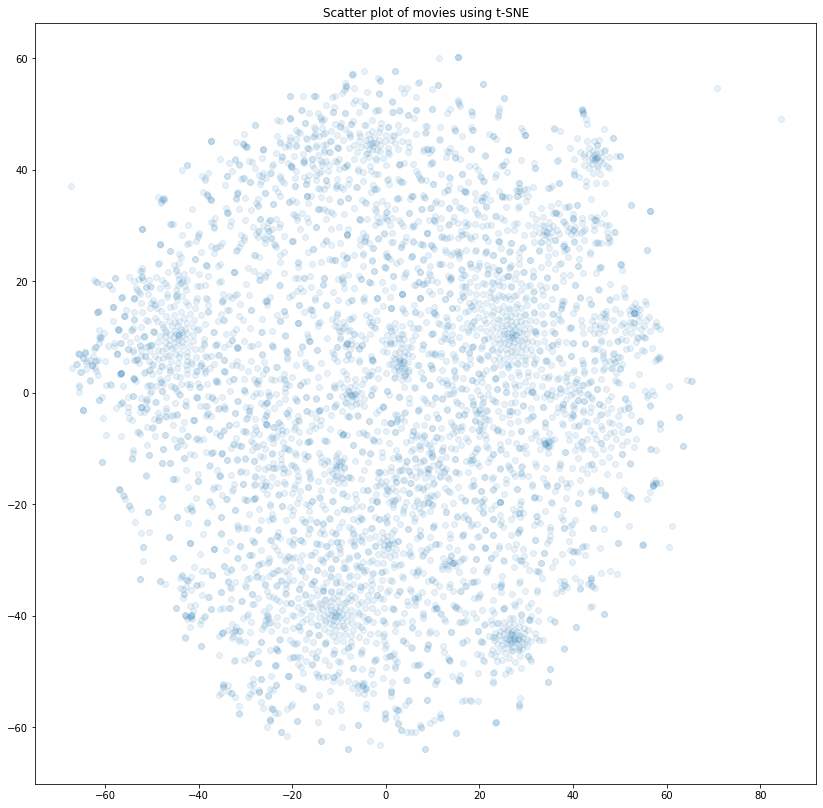

In [231]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=1, n_iter=1000, metric="cosine")

#次に、埋め込みマトリックスで fit andtransform を呼び出します。
embs = tsne.fit_transform(count_matrix)

# データフレームに追加
df['x'] = embs[:, 0]
df['y'] = embs[:, 1]

#散布図作成
plt.figure(figsize=(14, 14))
plt.scatter(embs[:, 0], embs[:, 1], alpha=.1)
plt.title('Scatter plot of movies using t-SNE')
plt.show()

In [229]:
try:
    from adjustText import adjust_text
except ImportError:
    def adjust_text(*args, **kwargs):
        pass

def adjust_text(*args, **kwargs):
    pass

FS = (13, 9)
def plot_region(x0, x1, y0, y1, text=True):
    """与えられた x と y の限界で囲まれた写像空間の領域をプロットします。 """
    fig, ax = plt.subplots(figsize=FS)
    pts = df[
        (df.x >= x0) & (df.x <= x1)
        & (df.y >= y0) & (df.y <= y1)
    ]
    ax.scatter(pts.x, pts.y, alpha=.6)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    if text:
        texts = []
        for label, x, y in zip(pts.title.values, pts.x.values, pts.y.values):
            t = ax.annotate(label, xy=(x, y))
            texts.append(t)
        adjust_text(texts, expand_text=(1.01, 1.05))
    return ax

def plot_region_around(title, margin=5, **kwargs):
    """指定されたタイトルで映画の近くのマッピングスペースの領域をプロットします。marginパラメータは、映画の周りの近傍のサイズを制御します。"""
    xmargin = ymargin = margin
    match = df[df.title == title]
    assert len(match) == 1
    row = match.iloc[0]

    return plot_region(row.x-xmargin, row.x+xmargin, row.y-ymargin, row.y+ymargin, **kwargs)



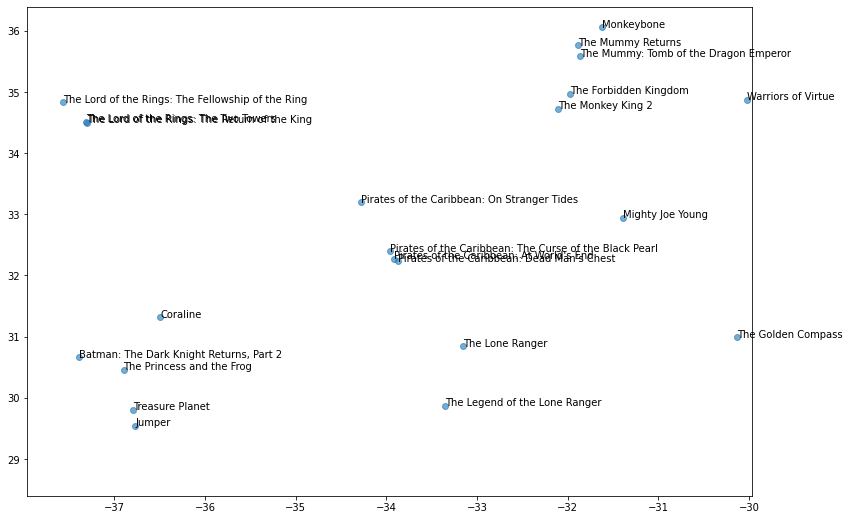

In [232]:
# 指定の映画の近傍(±4)の映画を可視化します
plot_region_around('Pirates of the Caribbean: The Curse of the Black Pearl',4)
plt.show()

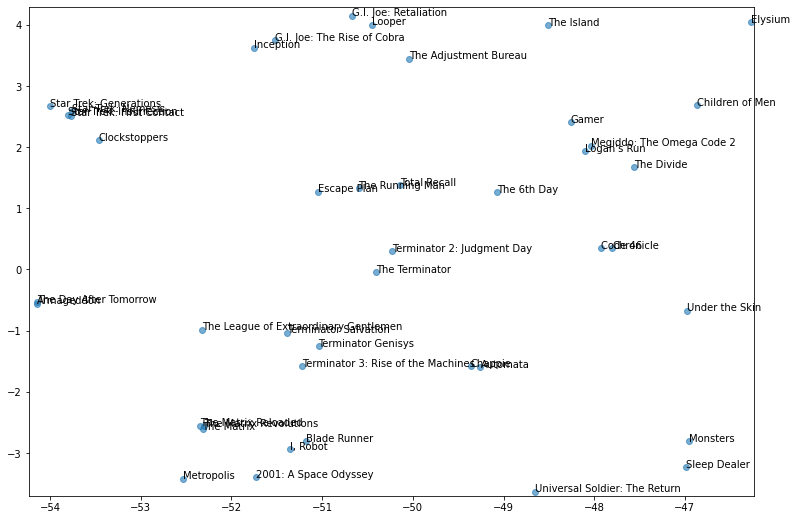

In [168]:
# 指定の映画の近傍(±4)の映画を可視化します
plot_region_around('Terminator 2: Judgment Day',4)
plt.show()

ここまで、コサイン類似度によるムービーレコメンデーションを体験いただきました。コサイン類似度によるコンテンツベースのレコメンデーションは最も基礎的なレコメンデーションアルゴリズムです。

これが理解できたら、次のステップに進みましょう。

私は、より高度で大規模な商用環境にまで対応できるハイブリッドレコメンデーションライブラリである、[LightFM](https://github.com/lyst/lightfm) をおすすめいたします。

- [Light FM 近似最近傍探索](02_ANN_annoy_nsmlib_example.ipynb)
- [Light FM Hybrid matrix factorisation model](https://github.com/microsoft/recommenders/blob/master/examples/02_model_hybrid/lightfm_deep_dive.ipynb)